<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2022</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 2</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

Consider the data files <code>daily-treasury-rates2018.csv</code>, <code>daily-treasury-rates2019.csv</code>, <code>daily-treasury-rates2020.csv</code>, <code>daily-treasury-rates2021.csv</code> and <code>daily-treasury-rates2022.csv</code>. They contain the United States Treasury's "Daily Yield Curve" data (sourced from www.treasury.gov) for the years 2018 to 2022. These rates are what the US Treasury calls "CMT rates" (see
https://www.treasury.gov/resource-center/faqs/Interest-Rates/Pages/faq.aspx).

***Importing Libraries***

In [29]:
import pandas as pd
from datetime import datetime
from pylab import plt, mpl
import numpy as np
from IPython.display import display, HTML, Math, Markdown
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.interpolate import interp1d

***Importing Data***

In [30]:
# Import new data set
df = pd.read_csv(r"daily-treasury-rates-all.csv")

# Convert times to the correct format
x = []
for i in range(0,len(df)):
    date = df.iat[i,0]
    new_date = datetime.strptime(str(date), "%m/%d/%Y")
    x.append(new_date)
df['Date'] = x

# Sort values by their date
df = df.sort_values(by='Date')

<H2>Task 1:</H2>
Convert these rates into continuously compounded yields. <I>(1 mark)</I>

***Converting the data***

***Using: $APY = 2\cdot ln\left (1 + \frac{I}{2}\right)$***

In [31]:
## Augment imported data
cmt_con = pd.DataFrame(df['Date'], columns = df
                       .columns)
column_arr = list(df.columns)[1:]

## Loop for every item in the dataframe
for i in range(0,len(column_arr)):
    col = str(column_arr[i])
    col1_int = (df[col]/100)
    col1 = 2*np.log(1+(col1_int/2))
    cmt_con[col] = col1

## New dataframe
cmt_con

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
248,2018-01-02,0.012859,NaN,0.014348,0.016036,0.018217,0.019108,0.020000,0.022374,0.023660,0.024450,0.026227,0.027904
247,2018-01-03,0.012859,NaN,0.014051,0.015837,0.018019,0.019307,0.020099,0.022374,0.023561,0.024252,0.026030,0.027609
246,2018-01-04,0.012759,NaN,0.014051,0.015936,0.018118,0.019505,0.020396,0.022572,0.023660,0.024450,0.026030,0.027707
245,2018-01-05,0.012660,NaN,0.013852,0.015738,0.017919,0.019505,0.020495,0.022770,0.023857,0.024549,0.026227,0.027904
244,2018-01-08,0.012958,NaN,0.014448,0.015936,0.017820,0.019505,0.020594,0.022770,0.023956,0.024746,0.026326,0.027904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,2022-08-29,0.024351,0.027313,0.029482,0.032927,0.034009,0.033911,0.034206,0.032436,0.031845,0.030959,0.034697,0.032239
1004,2022-08-30,0.024154,0.027115,0.029482,0.032829,0.034501,0.034304,0.034402,0.032436,0.031944,0.030861,0.034599,0.032042
1003,2022-08-31,0.023857,0.027017,0.029383,0.032927,0.034697,0.034206,0.034304,0.032731,0.032239,0.031255,0.034992,0.032436
1002,2022-09-01,0.025141,0.027806,0.029482,0.033124,0.034796,0.034796,0.035090,0.033616,0.033321,0.032337,0.036073,0.033419


In this data set, the <I>time to maturity</I> (not the time of maturity) is constant in each column. Thus, from the data in each column, we can obtain an estimate of the variance of the day-to-day changes in a continuously compounded yield with a given time to maturity. OK!

In order to relate this back to an HJM model, we need the dynamics of rates with fixed time to maturity in the model. 

We start with the instantaneous forward rates. The instantaneous forward rates $f(t,T)$ modelled in HJM have a fixed time of maturity $T$, with dynamics
$$
f(t,T)=f(0,T)+\int_0^t\sigma(u,T)\int_u^T\sigma(u,s)dsdu+\int_0^t\sigma(u,T)dW_{\beta}(u)\quad\forall\
t\in[0,T]
$$
Define instantaneous forward rates $r(t,x)$ with constant time to maturity $x$ by
$$
r(t,x)=f(t,t+x)
$$
The dynamics of $r(t,x)$ are given by the <I>Musiela equation</I> (for a proof, see e.g. Section 18.3 of Bj&ouml;rk, T. (1998) <I>Arbitrage Theory in Continuous Time</I>, Oxford University Press)
$$
r(t,x)=r(0,x)+\int_0^t\left(\frac{\partial}{\partial x}r(u,x)+\sigma(u,u+x)\int_0^x\sigma(u,u+s)ds\right)du+\int_0^t\sigma(u,u+x)dW_{\beta}(u)
$$

The continously compounded yield with constant time to maturity $x$ is
$$
y(t,x)=\frac1x\int_0^xr(t,s)ds
$$
Thus we have for the change in the continously compounded yield with constant time to maturity over a $\Delta t$ time step:
$$
y(t+\Delta t,x)-y(t,x)=\frac1x\int_0^x\left(\int_t^{t+\Delta t}\left(\frac{\partial}{\partial s}r(u,s)+\sigma(u,u+s)\int_0^s\sigma(u,u+v)dv\right)du+\int_t^{t+\Delta t}\sigma(u,u+s)dW_{\beta}(u)\right)ds
$$
Note that the drift will contribute to the variance of changes in the continously compounded yield via
$$
\frac{\partial}{\partial s}r(u,s),
$$
but for practical purposes this is negligible. Thus
\begin{aligned}
\text{Var}[y(t+\Delta t,x)-y(t,x)] &\approx& \text{Var}\left[\frac1x\int_0^x\int_t^{t+\Delta t}\sigma(u,u+s)dW_{\beta}(u)ds\right]\\
&=& \text{Var}\left[\frac1x\int_t^{t+\Delta t}\int_0^x\nu e^{-a(u+s-u)}dsdW_{\beta}(u)\right]\\
&=& \text{Var}\left[\frac1x\int_t^{t+\Delta t}\frac{\nu}a(1-e^{-ax})dW_{\beta}(u)\right]\\
&=& \left(\frac1x\frac{\nu}a(1-e^{-ax})\right)^2\Delta t
\end{aligned}

<H2>Task 2:</H2>
Assuming a one-factor Gauss/Markov HJM model with mean reversion fixed at $a = 0.1$, use all the data for the six-month yields to determine an appropriate choice of the volatility level $\nu$ (notation as above). For simplicity, you may assume that the data observations are equally spaced in calendar time. <I>(3 marks)</I>

***First, taking the 6 month data and converting it into a list, and setting some constants***

In [32]:
# Finding the delta t
length = (len(cmt_con))
ic = (((cmt_con.iat[length-1,0] - cmt_con.iat[0,0]).days)/365)/length

# Turning pd.Series into list
series = (cmt_con['6 Mo']).to_list()
x = 0.5 # half a year
a = 0.1 # given
deltat = ic # also given

In [33]:
# Loop, to find the absolute change between the rates
abs_change = []
for i in range(1,len(series)):
    app = series[i] - series[i-1]
    abs_change.append(app)

# Turn this into a np.array
array = np.array([abs_change])

# Use this to find standard deviaiton, square it to find variance, this is the left hand side of the equation
var = float((np.std(array))**2)

***Fairly confident we can make this problem easier to solve but coming at it at first algebraically, re-arranging the above equation, we land at the following formula:***

$$ \text{Var}[y(t+\Delta t,x)-y(t,x)] = \left(\frac1x\frac{\nu}a(1-e^{-ax})\right)^2\Delta t $$

$$ \sqrt{\frac{\text{Var}}{\Delta t}} = \frac{1}{x}\frac{\nu}{a}(1-e^{-ax})$$

$$ a = 0.1, \quad x = 0.5 $$

$$ \sqrt{\frac{\text{Var}}{\Delta t}} = \frac{1}{0.5}\frac{\nu}{0.1}(1-e^{-0.05}) $$

$$ 0.05 \cdot \sqrt{\frac{\text{Var}}{\Delta t}} = \nu(1-e^{-0.05}) $$

$$ \nu =  \frac{\left ( 0.05 \cdot \sqrt{\frac{\text{Var}}{(\Delta t)}} \right )}{(1-e^{-0.05})} $$

In [34]:
# Repeating the equation above
q2_sol = ( 0.05 * (np.sqrt( ( var ) / deltat ) ) ) / (1 - (np.exp(-0.05)))

# Print solution
display(Markdown('The solution to task 2 is: ' + str(q2_sol)))

The solution to task 2 is: 0.004853407659036588

<H2>Task 3:</H2>
Assuming a one-factor Gauss/Markov HJM model, use all the data for the one-month and thirty-year yields to determine an appropriate choice of the mean reversion parameter $a$ and volatility level $\nu$. For simplicity, you may assume that the data observations are equally spaced in calendar time. <I>(3 marks)</I>

***Using the above process, with the results above to produce a variance for 6 month and 30 year bond yields:***

In [35]:
# Pull the 6 months data
series = (cmt_con['6 Mo']).to_list()

# Find the absolute change between i and i-1
abs_change = []
for i in range(1,len(series)):
    app = series[i] - series[i-1]
    abs_change.append(app)

# Create an array, and find the variance
array = np.array([abs_change])
var_6mo = float((np.std(array))**2)

# Pull the 30 year data
series = (cmt_con['30 Yr']).to_list()

# Find the absolute change between i and i-1
abs_change = []
for i in range(1,len(series)):
    app = series[i] - series[i-1]
    abs_change.append(app)

# Create an array and find the variance
array = np.array([abs_change])
var_30yr = float((np.std(array))**2)

***Now we can use the following equations to get to some analytical result:***
$$ \sqrt{\frac{\text{Var}_{0.5}}{\Delta t}} = \frac{1}{0.5}\frac{\nu}{a}(1-e^{-a\cdot0.5})$$

$$ \sqrt{\frac{\text{Var}_{30}}{\Delta t}} = \frac{1}{30}\frac{\nu}{a}(1-e^{-a\cdot30})$$

$$ 0.5 \cdot \sqrt{\frac{\text{Var}_{0.5}}{(\Delta t)}} = \frac{\nu}{a}(1-e^{-a\cdot0.5})$$

$$ 30 \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}} = \frac{\nu}{a}(1-e^{-a\cdot30})$$

$$ \frac{30a \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}}}{(1-e^{-a\cdot30})}= \nu$$

$$ 0.5 \cdot \sqrt{\frac{\text{Var}_{0.5}}{(\Delta t)}} = \frac{\nu}{a}(1-e^{-a\cdot0.5})$$

$$ 0.5 \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}} = \frac{\frac{0.5 \cdot \sqrt{\frac{\text{Var}_{0.5}}{(\Delta t)}}}{(1-e^{-a\cdot30})}}{a}(1-e^{-a\cdot30})$$

$$ 0.5 \cdot \sqrt{\frac{\text{Var}_{0.5}}{(\Delta t)}} = \frac{30 \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}}}{{(1-e^{-a\cdot30}})}  (1-e^{-a\cdot0.5})$$

$$ \frac{0.5 \cdot \sqrt{\frac{\text{Var}_{0.5}}{(\Delta t)}}}{30 \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}}} = \frac{(1-e^{-0.5a})}{(1-e^{-30a})} $$

$$ 0 = \frac{(1-e^{-0.5a})}{(1-e^{-30a})} - \frac{0.5 \cdot \sqrt{\frac{\text{Var}_{0.5}}{(\Delta t)}}}{30 \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}}} $$

In [36]:
# Finding the constant value in the equation
num = 0.5 * (np.sqrt(var_6mo/(deltat)))
denom = 30 * (np.sqrt(var_30yr/(deltat)))
num_denom = num/denom

# Function for the variable of a
def q3(a:float):
    return ((1-np.exp(-0.5* a))/(1-np.exp(-30 * a))) - num_denom

# Finding the solution using fsolve
sol3 = fsolve(q3, 0.001)[0]

# Display solution
display(Markdown('The solution for a in quesiton 3 is: ' + str(sol3)))

The solution for a in quesiton 3 is: -0.03110955595580143

***We now know the solution for $a$, so now we can use it to solve for $\nu$ analystically using:***

$$ \frac{30a \cdot \sqrt{\frac{\text{Var}_{30}}{(\Delta t)}}}{(1-e^{-a\cdot30})}= \nu$$

In [37]:
# Using the above equation for find a solution for nu
nu3 = (30*sol3*np.sqrt(var_30yr/(deltat)))/(1-np.exp(-30*sol3))

# Display solution
display(Markdown('The solution for v in question 3 is: ' + str(nu3)))

The solution for v in question 3 is: 0.00469734644250805

A way in which the performance of a model for risk management purposes can be <B>backtested</B> is to use historical interest data to analyse what would have happened if one had used the model to hedge a derivative security in the past. This motivates the following Task:

<H2>Task 4:</H2>
Suppose that at the beginning of January 2022 you have sold an at-the-money caplet covering a three-month accrual period beginning in six months' time. 

If you hedge this caplet with rebalancing on every day for which there is data, using the natural hedge instruments, what would be your profit/loss when this option matures? 

Assume that caplet price and hedges are calculated using a one-factor Gauss/Markov HJM model with the parameters determined as in Task 3, but <B>using only data which would have been available at the time the caplet was sold</B>. 

Assume that any profit/loss is invested/borrowed by buying/selling the zero coupon bond maturing at the same time as the option. 

Repeat this for a caplet sold at the beginning of, respectively, April 2021, July 2021, and October 2021. Discuss the possible causes of profit/loss. <I>(13 marks)</I>

***Linear interpolation to create the new CMT rates:***

In [38]:
# Hide some errors
pd.options.mode.chained_assignment = None

# Take the first 1002 rows of the converterd cmt rates data
new_cmt_con = cmt_con.head(1002)

# Linearly interpolate the 9 month converted cmt rate
X = [0.5,1]
ix = []
for i in range(0,len(new_cmt_con)):
    Y = [new_cmt_con.iat[i,4], new_cmt_con.iat[i,5]]
    inter_x = 0.75
    y_interp = interp1d(X,Y)
    result = y_interp(inter_x)
    ix.append(result)
new_cmt_con['9 Mo'] = ix

***Overwriting delta t:***

In [39]:
# Finding the new delta t
length = len(new_cmt_con)
date_diff = ((new_cmt_con.iat[length-1,0] - new_cmt_con.iat[0,0]).days)/365
deltat = date_diff/length

***Finding the new mean reversion $a$ and volatility parameters $\nu$, taking the above data set to find the variance of the data, and applying the techniques from questions 2 and 3:***

In [40]:
series = (new_cmt_con['6 Mo']).to_list()
abs_change = []
for i in range(1,len(series)):
    app = series[i] - series[i-1]
    abs_change.append(app)

array = np.array([abs_change])
var_6mo = float((np.std(array))**2)

series = (new_cmt_con['9 Mo']).to_list()
abs_change = []
for i in range(1,len(series)):
    app = series[i] - series[i-1]
    abs_change.append(app)

array = np.array([abs_change])
var_9mo = float((np.std(array))**2)

num = 0.5 * (np.sqrt(var_6mo/(deltat)))
denom = 0.75 * (np.sqrt(var_9mo/(deltat)))
num_denom = num/denom

def q4(a:float):
    return ((1-np.exp(-0.5* a))/(1-np.exp(-0.75 * a))) - num_denom

solution = fsolve(q4, 0.01)

sol4 = float(solution[0])

a4 = sol4

nu4 = (0.75*sol4*np.sqrt(var_9mo/(deltat)))/(1-np.exp(-0.75*sol4))

display(Markdown('The solution for v in question 4 is: ' + str(nu4)))
display(Markdown('The solution for a in question 4 is: ' + str(a4)))

The solution for v in question 4 is: 0.004041717815009074

The solution for a in question 4 is: 0.48488170379234596

***Using the equation for a pricing a caplet can be represented as a put on a ZCB:***
$$ P = B(t,T_{i-1})KN(-h_2) - B(t,T_{i})N(-h_1) $$
$$ \text{where,    } \quad h_{1,2} = \frac{ln\frac{B(t,T_i)}{B(t,T_{i-1})\cdot K} \pm \int_{t}^{T_{i-1}} (\sigma^*(u,T_i) - \sigma^*(u,T_{i-1}))^2du  }{\sqrt{\int_{t}^{T_{i-1}}(\sigma^*(u,T_i) - \sigma^*(u,T_{i-1}))^2du}} $$

$$\text{Given the coupon bond volatilities formula in the lectures, we can do the following: }$$

$$ \sigma^*(t,T) = -\frac{\nu}{a} \cdot (e^{-a\cdot(T-t)} - 1)  $$

$$ \sigma^*(u,T_{i}) = -\frac{\nu}{a}\cdot (e^{-a\cdot(T_{i} - u)} - 1) \quad \text{and} \quad \sigma^*(u,T_{i-1}) = -\frac{\nu}{a}\cdot (e^{-a\cdot(T_{i-1} - u)} - 1)$$

$$ t = 0, \text{   } \nu, \text{   and   } a  \text{     are constants, so we solve the integral below  }$$

$$ \int_{t}^{T_{i-1}}  \left (-\frac{\nu}{a}\cdot (e^{-a\cdot(T_{i} - u)} - 1) +\frac{\nu}{a}\cdot (e^{-a\cdot(T_{i-1} - u)} - 1) \right )^2du  = \frac{\nu^2}{2a^3} \cdot (e^{aT_{i}} - e^{aT_{i-1}})^2 \cdot (e^{-2a(T_i+t+T_{i-1}} - e^{-2a(T_{i} + 2T_{i-1})})

$$

$$\text{Moving forward, let   } \delta =  \frac{\nu^2}{2a^3} \cdot (e^{aT_{i}} - e^{aT_{i-1}})^2 \cdot (e^{-2a(T_i+t+T_{i-1}} - e^{-2a(T_{i} + 2T_{i-1})})$$

$$\text{it follows that: } h_{1,2} = \frac{ln\frac{B(t,T_i)}{B(t,T_{i-1})\cdot K} \pm \delta}{\sqrt{\delta}} $$



***First we need to write a function for delta, and incorporating it into a formula for $h_1$ and $h_2$:***

In [41]:
def delta(nu:float,a:float,ti_1:float,ti:float,t:float):
    first_term = (nu**2)/(2*(a**3))
    second_term = (np.exp(a*ti) - np.exp(a*ti_1))**2
    third_term = (np.exp(-2*a*(ti+t+ti_1)) - np.exp(-2*a*(ti+(2*ti_1))))
    return first_term*second_term*third_term

def hs(k:float,nu:float,a:float,ti_1:float,ti:float,t:float,bti_1:float,bti:float):
    h12_1 = np.log(bti/(bti_1*k))
    h1 = (h12_1 + delta(nu,a,ti_1,ti,t))/(np.sqrt(delta(nu,a,ti_1,ti,t)))
    h2 = (h12_1 - delta(nu,a,ti_1,ti,t))/(np.sqrt(delta(nu,a,ti_1,ti,t)))
    return h1, h2

***Now a formula for the price of a put (for testing, whether I get crazy answers for the price):***

In [42]:
def CapletPrice(k:float,nu:float,a:float,ti_1:float,ti:float,t:float,bti_1:float,bti:float):
    res_1 = bti_1*k*norm.cdf(-hs(k,nu,a,ti_1,ti,t,bti_1,bti)[1])
    res_2 = bti*norm.cdf(-hs(k,nu,a,ti_1,ti,t,bti_1,bti)[0])
    return res_1 - res_2

***Finding the CMT rates so we can find zero coupon bond prices:***

In [43]:
# Take the old data for the CMT rates to find zcb prices
CMT_Data = pd.DataFrame(df['Date'], columns = df.columns)
cmts_names = list(df.columns)[1:]

## Loop for every item in the dataframe
for i in range(0,len(cmts_names)):
    col = str(cmts_names[i])
    col1 = df[col]/100
    CMT_Data[col] = col1

***Turning this dataframe into zero coupon bond prices at each maturity:***

In [44]:
maturities = [1/12,2/12,3/12,5/12,1,2,3,4,5,7,10,20,30]
mat_names = CMT_Data.columns.to_list()

y = []
for j in range(1,len(CMT_Data.columns)):
    col_sel = CMT_Data.iloc[:,j].to_list()
    mat = maturities[j]
    x= []
    for i in range(0,len(col_sel)):
        x.append(np.exp(-mat*col_sel[i]))
    y.append(x)

y = list(map(list, zip(*y)))
ZCB_Prices = pd.DataFrame(CMT_Data['Date'])
ydata = pd.DataFrame(y)
ZCB_Prices = pd.concat([ZCB_Prices, ydata], axis = 1)
ZCB_Prices.set_axis(mat_names, axis = 1, inplace = True)

***Linear interpolate 9 months ZCB Price data:***

In [45]:
_9mo = []
for i in range(0,len(CMT_Data)):
    Y1 = ZCB_Prices.iloc[i].to_list()[4]
    Y2 = ZCB_Prices.iloc[i].to_list()[5]
    y = list([Y1,Y2])
    x = list([0.5,1])
    inter_x = 0.75
    y_interp = interp1d(x,y)
    result = y_interp(inter_x)
    _9mo.append(result)
    
ZCB_Prices['9 Mo'] = _9mo

# New maturities 
maturities = [1/12,2/12,3/12,5/12,1,2,3,4,5,7,10,20,30,0.75]

ZCB_Prices

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,9 Mo
248,2018-01-02,0.995942,0.993894,0.989844,0.974725,0.948759,0.928300,0.906286,0.882056,0.834185,0.764143,0.563268,0.404138,0.9617421709848015
247,2018-01-03,0.996025,0.993844,0.990050,0.975505,0.949899,0.927187,0.904837,0.879853,0.831853,0.761854,0.561019,0.401720,0.9627018142973047
246,2018-01-04,0.995958,0.993869,0.990009,0.975407,0.949709,0.926075,0.903030,0.878095,0.828946,0.758054,0.557663,0.400517,0.9625580611211555
245,2018-01-05,0.995991,0.993943,0.989885,0.974920,0.949139,0.924687,0.901225,0.875027,0.825472,0.755028,0.555437,0.399317,0.9620294430663723
244,2018-01-08,0.995975,0.993943,0.989844,0.975115,0.949139,0.926353,0.902668,0.878974,0.830108,0.760332,0.562142,0.406570,0.9621269448028288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,2022-08-29,0.999917,0.999875,0.999583,0.997603,0.991437,0.974238,0.954278,0.927743,0.888429,0.838618,0.650509,0.530996,0.9945198759577885
1004,2022-08-30,0.999933,0.999875,0.999583,0.997703,0.991040,0.973945,0.955042,0.929136,0.890297,0.841138,0.654424,0.534192,0.9943715108731079
1003,2022-08-31,0.999917,0.999850,0.999625,0.997802,0.991834,0.975407,0.956954,0.930996,0.892793,0.842822,0.654424,0.534192,0.994817973259859
1002,2022-09-01,0.999900,0.999875,0.999667,0.997802,0.992429,0.977165,0.960021,0.933793,0.895924,0.847046,0.657047,0.537407,0.9951156126012202


***Now taking just the values we have before sale:***

In [46]:
ZCB_Prices_jan22 = ZCB_Prices.head(1002)
ZCB_Prices_jan22

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,9 Mo
248,2018-01-02,0.995942,0.993894,0.989844,0.974725,0.948759,0.928300,0.906286,0.882056,0.834185,0.764143,0.563268,0.404138,0.9617421709848015
247,2018-01-03,0.996025,0.993844,0.990050,0.975505,0.949899,0.927187,0.904837,0.879853,0.831853,0.761854,0.561019,0.401720,0.9627018142973047
246,2018-01-04,0.995958,0.993869,0.990009,0.975407,0.949709,0.926075,0.903030,0.878095,0.828946,0.758054,0.557663,0.400517,0.9625580611211555
245,2018-01-05,0.995991,0.993943,0.989885,0.974920,0.949139,0.924687,0.901225,0.875027,0.825472,0.755028,0.555437,0.399317,0.9620294430663723
244,2018-01-08,0.995975,0.993943,0.989844,0.975115,0.949139,0.926353,0.902668,0.878974,0.830108,0.760332,0.562142,0.406570,0.9621269448028288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,2021-12-28,0.999850,0.999775,0.999625,0.999100,0.997802,0.995809,0.991239,0.977262,0.946864,0.897628,0.720363,0.574072,0.9984514115524181
752,2021-12-29,0.999850,0.999775,0.999625,0.999100,0.997802,0.995809,0.992032,0.978729,0.949519,0.901225,0.726149,0.581003,0.9984514115524181
751,2021-12-30,0.999867,0.999775,0.999625,0.999100,0.998002,0.996108,0.993223,0.981179,0.954851,0.908464,0.742301,0.600496,0.9985512017729302
750,2021-12-31,0.999850,0.999775,0.999625,0.999100,0.998002,0.996705,0.993620,0.982161,0.956189,0.911194,0.746769,0.607745,0.9985512017729302


***Finding the zero coupon bond prices at each $T_{i}$, and finding the ATM ZCB prices for the $T_{i}$ bond:***

In [47]:
ZCB_Ti_1 = ZCB_Prices_jan22.iloc[len(ZCB_Prices_jan22)-1][4]
ZCB_Ti = ZCB_Prices_jan22.iloc[len(ZCB_Prices_jan22)-1][len(ZCB_Prices_jan22.columns)-1]

***So, for this one here we basically want to hedge a short position in the caplet. And so we have the following:***

***For hedging a short position in the caplet, we need to go long $N(-h_2)$ units of $B(t,T_{i-1})$, and short $(1+(T_i - T_{i-1})\kappa) \cdot N(-h_1)$ units of $B(t,T_{i})$.***

$$ \text{where } \kappa \text{ is the simple formard rate: } \quad \kappa = \frac{1}{T_i - T_{i-1}} \cdot \left ( \frac{B(t,T_{i-1})}{B(t,T_i)} -1 \right ) $$

***We can calculate this now, as it is constant as we move forward in time:***

$$ \text{Given } t_m = T_{i} \text{ , summing the value of the hedge, minus what you pay to the option holder.} $$ 
$$ \text{Also assuming that any interim profit or loss is invested or borrowed at the risk free rate (a bond of maturity 6 months (from the date of issuance) }. $$

$$ \text{This interest rate will change as we move through the data with each hedged position.}$$

$$ \text{From the above, we get the following sum for the P/L } \pi \text{ at each stage}$$

$$ \sum_{i=1}^{m} \pi(i \Delta t)e^{(r_{m_i} \cdot (T_i - i\Delta t))}$$

$$ \text{Breaking this down further } \text{At the first time step, we have the value of the hedge } $$

$$ \text{The long position in the bond expiring at } T_{i-1} \text{ funded by a short position of a bond expiring at the end of the accrural period } T_{i}$$

$$\text{Using the above derivation, and the } \delta \text{ constant above, assuming } \nu \text{ and } a \text{ remain unchanged as } t \rightarrow T_{i-1}$$ 

$$ h_{1,2}(t) = \frac{ln\frac{B(t,T_i)}{B(t,T_{i-1})\cdot K} \pm \delta}{\sqrt{\delta}} $$

***First, we need to find the zero coupon bond price data from $t = 0$ through to $t=T_{i-1}$:*** 

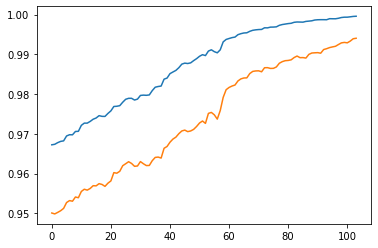

In [48]:
# Creating a dataframe of ZCB prices we need
ZCB_Prices_top_removal = ZCB_Prices.tail(169)
ZCB_Prices_bottom_removal = ZCB_Prices_top_removal.head(len(ZCB_Prices_top_removal)-1)
ZCB_Augment = pd.DataFrame(None)
ZCB_Augment['dt'] = ZCB_Prices_bottom_removal['Date']
ZCB_Augment['Date'] = 1
ZCB_Augment['Date + 1/12'] = ZCB_Prices_bottom_removal['1 Mo']
ZCB_Augment['Date + 1/6'] = ZCB_Prices_bottom_removal['2 Mo']
ZCB_Augment['Date + 0.25'] = ZCB_Prices_bottom_removal['3 Mo']
ZCB_Augment['Date + 0.5'] = ZCB_Prices_bottom_removal['6 Mo']
ZCB_Augment['Date + 1'] = ZCB_Prices_bottom_removal['1 Yr']

# Finding the delta t in each time step
dts = []
for i in range(0,len(ZCB_Augment)):
    dts.append(((ZCB_Augment.iat[i,0]-ZCB_Augment.iat[0,0]).days)/365)
ZCB_Augment['dt'] = dts

# Fining the first 6 months of this data
ZCB_Augment_first6mo = ZCB_Augment.head(104)

# Dataframe we want to fill
li = pd.DataFrame(None, columns = ['t', 'B(t,Ti-1)', 'B(t,Ti)'])
li['t'] = ZCB_Augment_first6mo['dt']

# Costant for delta t values
mats_addition = [1/12,2/12,0.25,0.5,1]

# Linear interpolation of ZCB prices at the evolving Ti as t moves from t -> Ti
for j in range(0,len(ZCB_Augment_first6mo)):
    test_set = ZCB_Augment_first6mo.iloc[j].to_list()[1:]
    dt_start = ZCB_Augment_first6mo.iat[j,0]
    mat_augment = [0]
    for i in range(0,len(mats_addition)):
        mat_augment.append((mats_addition[i]))

    X = mat_augment
    Y = test_set
    lin_interps = []
    x_inter = [0.5-dt_start,0.75-dt_start]
    for i in range(0,len(x_inter)):
        interpolate_x = (x_inter[i])
        y_interp = interp1d(X,Y)
        rate = y_interp(interpolate_x)
        lin_interps.append(float(rate))
        
    li.iat[j,1] = lin_interps[0]
    li.iat[j,2] = lin_interps[1]


# Plotting this data, intuition for results
li_list_1 = li['B(t,Ti-1)'].to_list()
li_list_2 = li['B(t,Ti)'].to_list()

plt.plot(li_list_1);
plt.plot(li_list_2);

***The graph above follows intution, for each timestep we move forward, we are getting the difference in time between the maturity of each ZCB decreased, meaning it should follow a trend that is the inverse of that of the below graph:***

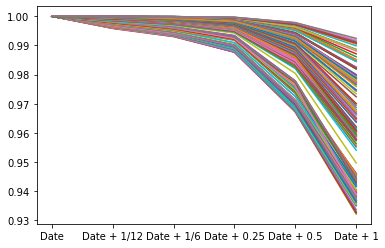

In [49]:
# What SHOULD the data sort of resemble
zcb_test_graph = ZCB_Augment.drop(columns = ['dt'])
zcb_test_graph = zcb_test_graph.T

plt.plot(zcb_test_graph);

***As the time to maturity of each of the bonds with the constanty maturities shrinks, the price of it at $t$ as $t \rightarrow T_{i-1}$ rises***

***Now we have the following, we can go forward and simulate the hedging process over $t \rightarrow T_{i-1}$***

***Below I expand on the formula above, so the cost of the hedge, and the rebalance at each timestep***

***Note: below I have re-named $T_{i-1}$ and $T_{i}$ to $T_{A}$ and $T_{B}$ respectively***

$$\text{For } 0<i<m, \text{ the profit, rebalancing the hedge at each timestep is:}$$

$$\pi(i\Delta t) = B(i\Delta t,T_{A})\cdot(N(-h_2((i-1)\Delta t)) - N(-h_2(i\Delta t))    ) $$ 

$$ - B(i\Delta t,T_{B}) \cdot \left ( N(-h_1((i-1)\Delta t)) \cdot \left (\frac{B((i-1)\Delta t, T_{A})}{B((i-1)\Delta t, T_{B})} \right ) - N(-h_1(\Delta t)) \cdot \frac{B(\Delta t, T_{A})}{B(\Delta t, T_{B})} \right )$$

$$\text{At the final timestep, the value of the portfolio is going to be the value of the hedge - the payoff of the caplet:}$$

$$\pi(m\Delta t) = B(m\Delta t,T_{A})\cdot(N(-h_2((m-1)\Delta t))) - B(m\Delta t,T_{B}) \cdot \left ( N(-h_1((m-1)\Delta t)) \cdot \left (\frac{B((m-1)\Delta t, T_{A})}{B((m-1)\Delta t, T_{B})} \right ) \right ) $$

$$ - (1 + (0.25)\cdot \kappa ) \cdot max ((1+(0.25\cdot\kappa))^{-1} - B(m\Delta t,T_B))  $$ 

$$\text{So, now we have the profit functions, we can implement the below formula, where } r_{m_i} \text{ is the 6 month interest rate (bond maturing at same time as option) at each  } t $$

$$ \sum_{i=1}^{m} \pi(i \Delta t)e^{(r_{m_i} \cdot (T_i - i\Delta t))}$$

$$\text{Also, must be noted that for } i\Delta t \text{ I use the individual timestep value, and for the } (i-1)\Delta t \text{, I use the previous }i\Delta t$$

$$\text{This question does not state to assume the same } \Delta t \text{across each period}$$


***For $0<i<m$, I find the below:***

In [50]:
nh1 = []
nh2 = []
nh1_1 = []
nh2_1 = []
for i in range(1,len(li)):
    nh1.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i,0],li.iat[i,1],li.iat[i,2])[0]))
    nh2.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i,0],li.iat[i,1],li.iat[i,2])[1]))
    nh1_1.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i-1,0],li.iat[i-1,1],li.iat[i-1,2])[0]))
    nh2_1.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i-1,0],li.iat[i-1,1],li.iat[i-1,2])[1]))

pi_i = []
for i in range(1,len(nh1)):
    ft = li.iat[i,1]*(nh2_1[i] - nh2[i])
    num_denom_1 = li.iat[i-1,1]/li.iat[i-1,2]
    num_denom_2 = li.iat[i,1]/li.iat[i,2]
    st_1 = li.iat[i,2]*((nh1_1[i]*num_denom_1) - (nh1[i]*num_denom_2))
    pi_i.append(ft - st_1)

***Now we need to find the profit in the last step, we know the values of $h_1$ and $h_2$ are 0 at the final step, so just using:***

$$ - (1 + (0.25)\cdot \kappa ) \cdot max ((1+(0.25\cdot\kappa))^{-1} - B(m\Delta t,T_B))  =  - \frac{B(t,T_{A})}{B(t,T_B)} \cdot max \left (0,\left (\frac{B(t,T_{A})}{B(t,T_B)}\right )^{-1} - B(m\Delta t,T_B)\right) $$

In [51]:
prof_final = -(li.iat[len(li)-1,1] / li.iat[len(li)-1,2])*(max(0, li.iat[len(li)-1,1] / li.iat[len(li)-1,2] - li.iat[len(li)-1,2]))

p_total = pi_i
p_total.append(prof_final)

***Now we must invest or borrow at the rf rate, which is the 6 month bond at each $t$:***

In [57]:
# Creating a new dataframe for our profit at each stage results
profit = pd.DataFrame(li['t'])
profit['Discount Factor'] = li['B(t,Ti-1)']
profit['Discounted Profit'] = None

x = []
for i in range(1,len(profit)):
    x.append(p_total[i-1]*profit.iat[i,1])

# Display the results
display(Markdown('The profit at the maturity is: ' + str(sum(x))))

# End of question results
eoq1 = []
eoq1.append(p_total[len(profit)-2])
eoq1.append (profit.iat[len(profit)-1,1])

The profit at the maturity is: -0.01159068040547415

***My understanding of the question is that the repeition of the above applied to caplets sold at each of the begining periods, that expire in 6 months, that run over a 3 months accrural period.***

***I have put this working into one fucntion that takes a set of data at each point, corresponding to those outlined in the question:***

In [63]:
# Hide some not really useful error  
pd.options.mode.chained_assignment = None

# Taking the above, and turning it into one function taking the bracket of data
# Only comments below are where I have market the change in these input variables
def agg_func(first:int,bottom:int,top:int):  
    
    # HERE - first  
    new_cmt_con = cmt_con.head(first)

    X = [0.5,1]
    ix = []
    for i in range(0,len(new_cmt_con)):
        Y = [new_cmt_con.iat[i,4], new_cmt_con.iat[i,5]]
        inter_x = 0.75
        y_interp = interp1d(X,Y)
        result = y_interp(inter_x)
        ix.append(result)

    new_cmt_con['9 Mo'] = ix

    length = len(new_cmt_con)
    date_diff = ((new_cmt_con.iat[length-1,0] - new_cmt_con.iat[0,0]).days)/365
    deltat = date_diff/length

    series = (new_cmt_con['6 Mo']).to_list()
    abs_change = []
    for i in range(1,len(series)):
        app = series[i] - series[i-1]
        abs_change.append(app)

    array = np.array([abs_change])
    var_6mo = float((np.std(array))**2)

    series = (new_cmt_con['9 Mo']).to_list()
    abs_change = []
    for i in range(1,len(series)):
        app = series[i] - series[i-1]
        abs_change.append(app)

    array = np.array([abs_change])
    var_9mo = float((np.std(array))**2)

    num = 0.5 * (np.sqrt(var_6mo/(deltat)))
    denom = 0.75 * (np.sqrt(var_9mo/(deltat)))
    num_denom = num/denom

    def q4(a:float):
        return ((1-np.exp(-0.5* a))/(1-np.exp(-0.75 * a))) - num_denom

    solution = fsolve(q4, 0.01)

    sol4 = float(solution[0])

    a4 = sol4

    nu4 = (0.75*sol4*np.sqrt(var_9mo/(deltat)))/(1-np.exp(-0.75*sol4))

    CMT_Data = pd.DataFrame(df['Date'], columns = df.columns)
    cmts_names = list(df.columns)[1:]

    for i in range(0,len(cmts_names)):
        col = str(cmts_names[i])
        col1 = df[col]/100
        CMT_Data[col] = col1
        
    maturities = [1/12,2/12,3/12,5/12,1,2,3,4,5,7,10,20,30]
    mat_names = CMT_Data.columns.to_list()

    y = []
    for j in range(1,len(CMT_Data.columns)):
        col_sel = CMT_Data.iloc[:,j].to_list()
        mat = maturities[j]
        x= []
        for i in range(0,len(col_sel)):
            x.append(np.exp(-mat*col_sel[i]))
        y.append(x)

    y = list(map(list, zip(*y)))
    ZCB_Prices = pd.DataFrame(CMT_Data['Date'])
    ydata = pd.DataFrame(y)
    ZCB_Prices = pd.concat([ZCB_Prices, ydata], axis = 1)
    ZCB_Prices.set_axis(mat_names, axis = 1, inplace = True)

    _9mo = []
    for i in range(0,len(CMT_Data)):
        Y1 = ZCB_Prices.iloc[i].to_list()[4]
        Y2 = ZCB_Prices.iloc[i].to_list()[5]
        y = list([Y1,Y2])
        x = list([0.5,1])
        inter_x = 0.75
        y_interp = interp1d(x,y)
        result = y_interp(inter_x)
        _9mo.append(result)
        
    ZCB_Prices['9 Mo'] = _9mo
     
    maturities = [1/12,2/12,3/12,5/12,1,2,3,4,5,7,10,20,30,0.75]

    # HERE - First
    ZCB_Prices_jan22 = ZCB_Prices.head(first)

    ZCB_Ti_1 = ZCB_Prices_jan22.iloc[len(ZCB_Prices_jan22)-1][4]
    ZCB_Ti = ZCB_Prices_jan22.iloc[len(ZCB_Prices_jan22)-1][len(ZCB_Prices_jan22.columns)-1]

    # HERE - Top
    ZCB_Prices_top_removal = ZCB_Prices.tail(top)
    # HERE - Bottom
    ZCB_Prices_bottom_removal = ZCB_Prices_top_removal.head(bottom)
    ZCB_Augment = pd.DataFrame(None)
    ZCB_Augment['dt'] = ZCB_Prices_bottom_removal['Date']
    ZCB_Augment['Date'] = 1
    ZCB_Augment['Date + 1/12'] = ZCB_Prices_bottom_removal['1 Mo']
    ZCB_Augment['Date + 1/6'] = ZCB_Prices_bottom_removal['2 Mo']
    ZCB_Augment['Date + 0.25'] = ZCB_Prices_bottom_removal['3 Mo']
    ZCB_Augment['Date + 0.5'] = ZCB_Prices_bottom_removal['6 Mo']
    ZCB_Augment['Date + 1'] = ZCB_Prices_bottom_removal['1 Yr']

    dts = []
    for i in range(0,len(ZCB_Augment)):
        dts.append(((ZCB_Augment.iat[i,0]-ZCB_Augment.iat[0,0]).days)/365)

    ZCB_Augment['dt'] = dts

    ZCB_Augment_first6mo = ZCB_Augment.head(104)

    li = pd.DataFrame(None, columns = ['t', 'B(t,Ti-1)', 'B(t,Ti)'])
    li['t'] = ZCB_Augment_first6mo['dt']

    mats_addition = [1/12,2/12,0.25,0.5,1]

    for j in range(0,len(ZCB_Augment_first6mo)):
        test_set = ZCB_Augment_first6mo.iloc[j].to_list()[1:]
        dt_start = ZCB_Augment_first6mo.iat[j,0]
        mat_augment = [0]
        for i in range(0,len(mats_addition)):
            mat_augment.append((mats_addition[i]))

        X = mat_augment
        Y = test_set
        lin_interps = []
        x_inter = [0.5-dt_start,0.75-dt_start]
        
        #print(X,Y,x_inter)
        for i in range(0,len(x_inter)):
            interpolate_x = (x_inter[i])
            y_interp = interp1d(X,Y)
            rate = y_interp(interpolate_x)
            lin_interps.append(float(rate))
            
        li.iat[j,1] = lin_interps[0]
        li.iat[j,2] = lin_interps[1]

    li_list_1 = li['B(t,Ti-1)'].to_list()
    li_list_2 = li['B(t,Ti)'].to_list()

    nh1 = []
    nh2 = []
    nh1_1 = []
    nh2_1 = []
    for i in range(1,len(li)):
        nh1.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i,0],li.iat[i,1],li.iat[i,2])[0]))
        nh2.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i,0],li.iat[i,1],li.iat[i,2])[1]))
        nh1_1.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i-1,0],li.iat[i-1,1],li.iat[i-1,2])[0]))
        nh2_1.append(norm.cdf(-hs(ZCB_Ti_1,nu4,a4,0.5,0.75,li.iat[i-1,0],li.iat[i-1,1],li.iat[i-1,2])[1]))

    pi_i = []
    for i in range(1,len(nh1)):
        ft = li.iat[i,1]*(nh2_1[i] - nh2[i])
        num_denom_1 = li.iat[i-1,1]/li.iat[i-1,2]
        num_denom_2 = li.iat[i,1]/li.iat[i,2]
        st_1 = li.iat[i,2]*((nh1_1[i]*num_denom_1) - (nh1[i]*num_denom_2))
        pi_i.append(ft - st_1)
        
    prof_final = -(li.iat[len(li)-1,1] / li.iat[len(li)-1,2])*(max(0, li.iat[len(li)-1,1] / li.iat[len(li)-1,2] - li.iat[len(li)-1,2]))

    p_total = pi_i
    p_total.append(prof_final)

    profit = pd.DataFrame(li['t'])

    profit['Discount Factor'] = li['B(t,Ti-1)']

    profit['Discounted Profit'] = None

    x = []
    for i in range(1,len(profit)):
        x.append(p_total[i-1]*profit.iat[i,1])
    
    return x, [p_total[len(profit)-2],profit.iat[len(profit)-1,1]]

# Inputs for the function
brackets = [[789,252,62],[876,295,65],[940,130,65]]
time =['April', 'June', 'October']

# Display results
eoq2 = []
for i in range(0,len(brackets)):
    display(Markdown('The profit at the maturity is (for the caplet written in '+str(time[i])+' is): ' + str(sum(agg_func(brackets[i][0],brackets[i][1],brackets[i][2])[0]))))
    eoq2.append(agg_func(brackets[i][0],brackets[i][1],brackets[i][2])[1])

The profit at the maturity is (for the caplet written in April is): -0.013206947635948998

The profit at the maturity is (for the caplet written in June is): -0.014061560327655754

The profit at the maturity is (for the caplet written in October is): -0.014061518807049828

The profit for each of these I think is primarily dependent on the value of the caplet at expiration and the the discount factor thats associated with the investment/loss. This can be seen in the results below. The bulk of the costs is this pay out at the end of the period, I feel this is because the values from profit or loss in the hedging process are so small, you just end up with the final hedge.

The bonds written in June and October of 2021 are so similar, it is hard to find the reason behind the extremely minor disparity in the results.

With the caplet written in April of 2021, we have a bigger loss than the other periods, but the discount factor is lower, and the product of this leaves us with an actual npv of the loss being lower than the two affordmentioned caplets, which incur a loss that is marginally larger.

This goes for the bond written at the begining of January 2022 also, where we have a smaller loss, in addition to a lower discount factor resuting in a much lower profit or loss value.

I believe, although the changing values of $h_{1,2}$ being susceptible to market volatility, and including those in the equation for the hedging, does mean that these values, and varying volatility of these periods should affect the size of the hedge, and more so the size of potential profit or loss - but the values of h1 and h2 are so small I think the effect is negligible realtive to the final payout.

In [65]:
display(eoq1,eoq2)
display(eoq1[0]*eoq1[1])

[-0.01159561910785682, 0.9995740889437008]

[[-0.004256428228675404, 0.9995798916192674],
 [-0.004047316960290569, 0.9996712416716677],
 [-0.004047316960290569, 0.9996712416716677]]

-0.01159068040547415

In [ ]:
#!jupyter nbconvert --to html AssignmentPart2_FirstAttempt_14392144_.ipynb